# Group 5 - Module 2: Recommendation Systems

***
### Group Members:
* **Nils Dunlop, 20010127-2359, Applied Data Science, e-mail: gusdunlni@student.gu.se (14 hours)**
* **Francisco Erazo, 19930613-9214, Applied Data Science, e-mail: guserafr@student.gu.se (14 hours)**

#### **We hereby declare that we have both actively participated in solving every exercise. All solutions are entirely our own work, without having taken part of other solutions." (This is independent and additional to any declaration that you may encounter in the electronic submission system.)**

# Assignment 3
***

## Problem 1: Reading and Reflection: "The Hidden Technical Debt in Machine Learning Systems".
***

### Key Takeaways:
- **Complexity and Maintenance Costs:** Machine learning systems present unique challenges in software engineering such as notable high maintenance costs and complexity due to ML-specific issues leading to technical debt.
- **System-Level Issues:** The paper outlines system-level issues like boundary erosion, entanglement, hidden feedback loops, undeclared consumers, and data dependencies that contribute significantly to technical debt in ML systems.
- **Data Dependencies:** Data dependencies in ML systems are harder to detect and manage which could lead to unstable and underutilized data dependencies that increase technical debt.
- **Feedback Loops and Anti-Patterns:** Feedback loops can influence ML system behavior which can complicate maintenance. The paper also mentions the system design anti-patterns such as glue code, pipeline jungles, dead experimental codepaths, and abstraction debt which can exacerbate technical debt.
- **Configuration Debt:** The configuration of ML systems can become complex and error-prone which can contribute to technical debt.

### Design Features:
- **Awareness and Mitigation:** Awareness of technical debt and proactive mitigation strategies are essential for maintaining and evolving ML systems efficiently.
- **System Design Considerations:** The paper emphasizes the importance of considering ML-specific issues in system design to prevent the accrual of technical debt.
- **Cultural Shift in ML Teams:** Encourages a cultural shift in ML teams to prioritize technical debt reduction alongside model accuracy improvements for the long-term health of ML systems.

## Problem 2: Implementation
***

In [15]:
import pandas as pd
from sklearn.cluster import KMeans
from scipy.stats import mode
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

df_beijing = pd.read_csv('Beijing_labeled.csv')
df_chengdu = pd.read_csv('Chengdu_labeled.csv')
df_guangzhou = pd.read_csv('Guangzhou_labeled.csv')
df_shanghai = pd.read_csv('Shanghai_labeled.csv')
df_shenyang = pd.read_csv('Shenyang_labeled.csv')

df_beijing

,season,DEWP,HUMI,PRES,TEMP,Iws,precipitation,cbwd_NE,cbwd_NW,cbwd_SE,PM_HIGH
0,4,-8.0,79.0,1026.0,-5.0,23.69,0.0,0,0,1,1.0
1,4,-11.0,85.0,1021.0,-9.0,105.93,1.1,0,0,1,0.0
2,4,-21.0,43.0,1030.0,-11.0,117.55,0.0,0,1,0,0.0
3,4,-25.0,33.0,1034.0,-12.0,39.35,0.0,1,0,0,0.0
4,4,-24.0,30.0,1034.0,-10.0,59.00,0.0,1,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2066,4,-15.0,45.0,1040.0,-5.0,1.79,0.0,0,1,0,0.0
2067,4,-13.0,34.0,1036.0,1.0,40.24,0.0,0,1,0,0.0
2068,4,-8.0,50.0,1028.0,1.0,1.79,0.0,0,1,0,1.0
2069,4,-11.0,28.0,1031.0,6.0,23.24,0.0,0,1,0,0.0


In [16]:
# Combine the datasets for Beijing, Chengdu, and Shenyang
df_combined = pd.concat([df_beijing, df_chengdu, df_shenyang], ignore_index=True)

# Reset the index to avoid any potential issues with non-sequential indices
df_combined.reset_index(drop=True, inplace=True)

# Split the combined dataset into features and target
X_combined = df_combined.drop(columns=['PM_HIGH'])
y_combined = df_combined['PM_HIGH']

# Split the combined dataset into training and validation sets
X_train_combined, X_val_combined, y_train_combined, y_val_combined = train_test_split(
    X_combined, y_combined, test_size=0.2, random_state=42)


# Prepare the testing sets for Guangzhou and Shanghai
X_test_guangzhou = df_guangzhou.drop(columns=['PM_HIGH']).reset_index(drop=True)
y_test_guangzhou = df_guangzhou['PM_HIGH'].reset_index(drop=True)

X_test_shanghai = df_shanghai.drop(columns=['PM_HIGH']).reset_index(drop=True)
y_test_shanghai = df_shanghai['PM_HIGH'].reset_index(drop=True)

In [17]:
class KMeansClassifier:
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters
        self.kmeans = KMeans(n_clusters=self.n_clusters)
        self.labels_map = {}
        self.inertia_ = None

    def fit(self, X, y):
        # Fit the k-means algorithm to the data
        self.kmeans.fit(X)
        self.inertia_ = self.kmeans.inertia_

        # Predict the clusters
        clusters = self.kmeans.predict(X)

        # Create a mapping from each cluster to a label
        for cluster in range(self.n_clusters):
            cluster_indices = np.where(clusters == cluster)[0]
            cluster_labels = y.iloc[cluster_indices]
            majority_label = mode(cluster_labels, keepdims=False).mode

            # Ensure that majority_label is treated as an array
            if np.isscalar(majority_label):
                majority_label = np.array([majority_label])

            # Map the cluster to the majority label
            self.labels_map[cluster] = majority_label[0]

    def predict(self, X):
        # Find the nearest centroid for each point in X
        clusters = self.kmeans.predict(X)

        # Predict the label based on the nearest centroid
        predicted_labels = np.vectorize(self.labels_map.get)(clusters)
        return predicted_labels

    def score(self, X, y):
        # Predict the labels for X
        predicted_labels = self.predict(X)

        # Calculate the accuracy as the fraction of correctly predicted labels
        accuracy = np.mean(predicted_labels == y)
        return accuracy


In [18]:
# Initialize the classifier
# Optimal number of clusters was determined below to be 2
classifier = KMeansClassifier(n_clusters=1)

# Train the classifier on the combined training set
classifier.fit(X_train_combined, y_train_combined)

# Training accuracy
training_accuracy = classifier.score(X_train_combined, y_train_combined)

# Validate the classifier on the combined validation set
validation_accuracy = classifier.score(X_val_combined, y_val_combined)

# Evaluate on Guangzhou data
test_accuracy_guangzhou = classifier.score(X_test_guangzhou, y_test_guangzhou)

# Evaluate on Shanghai data
test_accuracy_shanghai = classifier.score(X_test_shanghai, y_test_shanghai)

print(f"Training Accuracy (Beijing, Chengdu, Shenyang): {training_accuracy:.2f}")
print(f"Validation Accuracy (Beijing, Chengdu, Shenyang): {validation_accuracy:.2f}")
print(f"Test Accuracy for Guangzhou: {test_accuracy_guangzhou:.2f}")
print(f"Test Accuracy for Shanghai: {test_accuracy_shanghai:.2f}")

/Users/faerazo/opt/miniconda3/envs/general/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training Accuracy (Beijing, Chengdu, Shenyang): 0.72
Validation Accuracy (Beijing, Chengdu, Shenyang): 0.73
Test Accuracy for Guangzhou: 0.94
Test Accuracy for Shanghai: 0.90


/Users/faerazo/opt/miniconda3/envs/general/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/faerazo/opt/miniconda3/envs/general/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/faerazo/opt/miniconda3/envs/general/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/faerazo/opt/miniconda3/envs/general/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

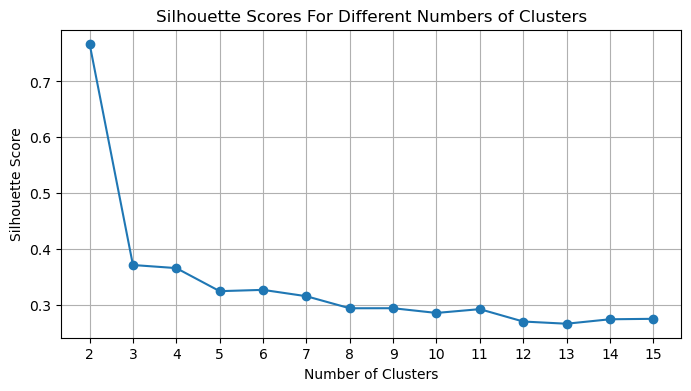

In [19]:
# Apply the silhouette score method
silhouette_scores = []
cluster_range = range(2, 16)

# Calculate the silhouette score for each number of clusters
for n_clusters in cluster_range:
    classifier = KMeansClassifier(n_clusters=n_clusters)
    classifier.fit(X_train_combined, y_train_combined)

    # Calculate the silhouette score
    silhouette_avg = silhouette_score(X_train_combined, classifier.kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores For Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

## Problem 3: Discussion
***

### In most cases, the accuracy of a system when deployed is lower than the accuracy measured during development (training).Was this the case for your system?
In fact, the accuracy of the system when deployed is lower than the accuracy measured during development (training) is a common scenario in machine learning there are several reasons, like overfitting, model complexity, distribution and data shift, variability, model and concept drift, and so on. 

In our model, this was not the case. In contrast, the validation accuracy (0.73) was higher than the training accuracy (0.72). This is not expected, but a priori it could suggest that the model generalizes well to unseen data from the same distribution. 

Something to remark, is that when the model was tested on the data from Guangzhou and Shanghai, the test accuracy were significantly higher that both the training and valdiation accuracy metrics, at 0.94 and 0.90, respectively. This is a rare case, but it can happen. It is usual to see a drop in performance when models are testes on new data. However, we know that there are some particularities in the data that could explain this behavior.

### What are possible reasons for this?
- **Imbalanced Label (PM_HIGH)**: The training data has an imbalance ratio of 2.54 between the two classes (0:2300, 1:904). This imbalance may cause that the model is biased towards the class 0, because the clusters are likely to contain more instances of this class, leading to the majority label for each centroid being 0. That's why on the validation dataset (0:581, 1:220) accuracy we were able to see this bias. 

- **Imbalanced Learning**: The model was trained using the KMeans algorithm, which is an unsupervised learning algorithm. This algorithm is not designed to handle imbalanced data, it is primarly designed to minimize the sum of squared distances between data points and cluster centroids. As it is mentioned before it is likely that the clusters are not balanced because this algorithm does not aim to produce balanced clusters. This could lead to the model being biased towards the class 0, which is the case for the training and validation datasets.

- **Data Preprocessing**: We didn't implement any preprocessing techniques to handle the imbalance in the data. This could have been done by using techniques such as oversampling, undersampling, SMOTE, class weighting, stratetify parameter in the split, etc. This could have helped to overcome the imbalance between the classes and reduce the bias of the model. For example, using K-Means SMOTE. 

- **Test Data Characteristics**: Even though both, the training and test datasets show a similar distribution and imbalance problem, the test datasets are extremely imbalanced than the training dataset. The test datasets for Guangzhou and Shanghai exhibited a ratio of 14.72 (0: 1266, 1: 86) and 9.16 (0: 1218, 1: 133). This aligns perfectly with the bias of the model at prediciting the majority class. It suggests that the model's superior performance on the test datasets is due the imbalance class distributions rather than an actual understanding of the underlying patterns in the data. In other words, these datasets were easier for the model to classify because they are hugely imbalanced, resulting in inflated accuracy.

- **Misleading Metric for Evaluation**: Accuracy is not the best metric to evaluate the performance of this model. It can provide a general view of the model capabilities, but it fails when the data is imbalanced. Considering the evident imbalance ratios in our test datasets, this high accuracy achieved is the result of the model just predicting the predominant class (0). Other metrics, should be used to evaluate the performance of the model, such as precision, recall, F1-score, AUC-ROC, etc.

- **Cluster to Label Mapping**: The requirement of mapping the clusters to labels (based on assignining each centroid label that corresponds to the majority label of points in the cluster) was particulaty effective considering the characteristics of the test datasets mentioned aboved, leading to the high accuracy metrics.

### Discuss which assumptions are made during development that may not hold, and what could be done to improve the system. Do these assumptions hold for the problem above?
During the development of the KMeans system, we made several assumptions that may not hold in practice. Some of these assumptions include:
- **Assumption 1: All Features are Numerical (DO NOT HOLD)**: 
    - **Assumption**: The features used in the model are only numerical and can be used to calculate the distance between data points.
    - **Reality**: There some features used in the model, that are categorical. For example, `season` (1,2,3,4) which presumably represent winter, spring, summer and autumn, `cbwd_NE`, `cbwd_NW`, and `cbwd_SE` with values between 0 or 1 which could represent dummy variables. This implies that features are a mix of continuous and categorical features, and the K-Means algorithm is not designed to handle categorical features, it assumes that the features are continuous and it is not appropriate to use with dummy variables.
    - **Improvement**: We could remove the categorical features from the model, or use a different algorithm like K-Prototypes, which is an extension of K-Means that can handle both numerical and categorical features.
- **Assumption 2: Homogeneity of Data for Different Cities (DO NOT HOLD)**: 
    - **Assumption**: The underlying patterns or model and the distritiong of PM are similar across the cities, allowing the model to be trained on a subset of cities (Beijing, Chengdu and Shenyang) and expected to perform well on the test datasets from Guangzhou and Shanghai.
    - **Reality**: The data from different cities may have different characteristics and distributions due to factors like environmental conditions, topography, population, urban planning, industrial development that are not considered in the data. In addition, the data from Guangzhou and Shanghai had a more marked imbalance problem compared to the training and validation datasets. This differences can influence the model when applies to new locations.
    - **Improvement**: To improve the system, we could consider developing a model for each city, or at least for each region, we could also incoorate city-speficic features, if it not expensive to collect. Another approach could use a city feature as a input to the model, so the model can learn the differences between the cities.
- **Assumption 3: Cluster are Related with Pollution Levels (WE NEED A DEEPER ANALYSIS ON THE RELATIONSHIP)**:
    - **Assumption**: The clusters that are formed by the K-Means algorithm are related to the pollution levels (PM_HIGH).
    - **Reality**: It is not guarantee that clusters will align with PM_HIGH. The K-Means algorithm is not designed to produce clusters that are related to the target variable, it is an unsupervised method, designed to minimize the sum of squared distances between data points and cluster centroids.
    - **Improvement**: We could use a supervised learning classification algorithm to predict the correct label of an instance (0 or 1 for PM_HIGH) based on the features of the instance. This would allow the model to learn the relationship between the features and the target variable, and would likely improve the performance of the model. Some of the supervised learning algorithms that could be used are Random Forest, XGBoost, SVM, Logistic Regression, etc.
- **Assumption 4: Map the Cluster to the Majority Label (WE NEED TO CHECK HOW THIS WOULD PERFORM IN A MORE BALANCED DATASET)**:
    - **Assumption**: The majority label of the points in a cluster accurately represents all members of that cluster. 
    - **Reality**: The majority label of the points in a cluster may not be a good representation of the cluster. This method simplify the relationship between the features and labels, specially in clusters where the label distribution are imbalaced. The majority label could lead to the model being biased towards the majority class, which is the case for the validation and testing datasets.
    - **Improvement**: Again this will depends on what we want to achieve with the model. If we want to predict the majority class, then this method is good but useless. If we want to classify unseen data into the correct class, then we should use a supervised learning classification algorithm. 
- **Assumption 5: Accuracy as the Evaluation Metric (DO NOT HOLD)**
    - **Assumption**: Accuracy is a good metric to evaluate the performance of the model.
    - **Reality**: Given the imbalanced nature of the data (more instances of class 0 than class 1), accuracy may not capture the true predictive power of the model, specially its ability to correctly identify the minority class in PM_HIGH.
    - **Improvement**: We should use other metrics to evaluate the performance of the model, such as precision, recall, F1-score, AUC-ROC, Precision-Recall curve, etc. These metrics are better suited to evaluate the performance of the model when the data is imbalanced.
- **Assumption 6: The Model Generalizes Well on Unseen Data (DO NOT HOLD)**
    - **Assumption**: The high test accuracies on the Guangzhou and Shanghai datasets suggest that the model is performance well on new datasets.
    - **Reality**: This might be due to the mentioned imbalance problem in the test datasets, and not because the model has learned generalizable features from the training data.
    - **Improvement**: We should use a supervised learning classification algorithm and additionally implement techniques to handle the imbalance in the data before training. 

## References: 
***
- Huang, Z. and Ng, M.K. (2003). A Note on K-modes Clustering. Journal of Classification, [online] 20(2), pp.257–261. doi:https://doi.org/10.1007/s00357-003-0014-4.
- Brownlee, J. (2019). A Gentle Introduction to Imbalanced Classification - MachineLearningMastery.com. [online] MachineLearningMastery.com. Available at: https://machinelearningmastery.com/what-is-imbalanced-classification/ [Accessed 4 Feb. 2024].
- Daneel Olivaw (2024). Parameter ‘stratify’ from method ‘train_test_split’ (scikit Learn). [online] Stack Overflow. Available at: https://stackoverflow.com/questions/34842405/parameter-stratify-from-method-train-test-split-scikit-learn [Accessed 4 Feb. 2024].
- Brownlee, J. (2020). Imbalanced Classification with the Fraudulent Credit Card Transactions Dataset - MachineLearningMastery.com. [online] MachineLearningMastery.com. Available at: https://machinelearningmastery.com/imbalanced-classification-with-the-fraudulent-credit-card-transactions-dataset/ [Accessed 4 Feb. 2024].
- Brownlee, J. (2020). Step-By-Step Framework for Imbalanced Classification Projects - MachineLearningMastery.com. [online] MachineLearningMastery.com. Available at: https://machinelearningmastery.com/framework-for-imbalanced-classification-projects/ [Accessed 4 Feb. 2024].
- Brownlee, J. (2020). Why Is Imbalanced Classification Difficult? - MachineLearningMastery.com. [online] MachineLearningMastery.com. Available at: https://machinelearningmastery.com/imbalanced-classification-is-hard/ [Accessed 4 Feb. 2024].
- Brownlee, J. (2020). Cost-Sensitive Logistic Regression for Imbalanced Classification - MachineLearningMastery.com. [online] MachineLearningMastery.com. Available at: https://machinelearningmastery.com/cost-sensitive-logistic-regression/ [Accessed 4 Feb. 2024].
- Brownlee, J. (2020). How to Combine Oversampling and Undersampling for Imbalanced Classification - MachineLearningMastery.com. [online] MachineLearningMastery.com. Available at: https://machinelearningmastery.com/combine-oversampling-and-undersampling-for-imbalanced-classification/ [Accessed 4 Feb. 2024].
- Georgios Douzas and Bacao, F. (2018). Improving imbalanced learning through a heuristic oversampling method based on k-means and SMOTE. Information Sciences, [online] 465, pp.1–20. doi:https://doi.org/10.1016/j.ins.2018.06.056.

## Self Check
***
- Have you answered all questions to the best of your ability?
Yes, we have.
- Is all the required information on the front page, is the file name correct etc.?
Indeed, all the required information on the front page has been included.
- Anything else you can easily check? (details, terminology, arguments, clearly stated answers etc.?)
We have checked, and everything looks good.